In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ccba = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_ccba_full_hashed.csv')
cdtx = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_cdtx0001_full_hashed.csv')
custinfo = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_custinfo_full_hashed.csv')
dp = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_dp_full_hashed.csv')
remit = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_remit1_full_hashed.csv')
p_date = pd.read_csv('/home/bill/moneylaundring/dataset/public_x_alert_date.csv')
t_date = pd.read_csv('/home/bill/moneylaundring/dataset/train_x_alert_date.csv')
answer = pd.read_csv('/home/bill/moneylaundring/dataset/train_y_answer.csv')

In [3]:
ccba_merge = ccba.groupby('cust_id')
new_ccba = ccba_merge['cycam'].max()
new_ccba = pd.DataFrame(new_ccba)


In [4]:
cinfo = custinfo.merge(new_ccba,on='cust_id',how='outer')
cinfo = cinfo.merge(t_date, on='alert_key')
cinfo = cinfo.merge(answer, on='alert_key')

In [5]:
cinfo['cycam'].fillna(0,inplace=True)

In [6]:
cinfo[cinfo['cycam'].isna()]

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,cycam,date,sar_flag


In [7]:
cinfo.isna().any()

alert_key          False
cust_id            False
risk_rank          False
occupation_code     True
total_asset        False
AGE                False
cycam              False
date               False
sar_flag           False
dtype: bool

In [8]:
cinfo['occupation_code'].fillna(21,inplace=True)

In [9]:
cdtx = pd.merge(cinfo, cdtx, left_on=['cust_id','date'], right_on=['cust_id','date'])
dp = pd.merge(cinfo, dp, left_on=['cust_id','date'], right_on=['cust_id','tx_date'])
remit = pd.merge(cinfo, remit, left_on=['cust_id','date'], right_on=['cust_id','trans_date'])

In [10]:
cdtx_X = cdtx[['risk_rank','occupation_code','total_asset','AGE','cycam','country','cur_type','amt','date']]
cdtx_y = cdtx[['sar_flag']]
cdtx_idx = cdtx[['alert_key']]

In [11]:
from sklearn.model_selection import train_test_split
cdtx_X_train, cdtx_X_test, cdtx_y_train, cdtx_y_test , cdtx_train_indices, cdtx_test_indices= train_test_split(cdtx_X, cdtx_y, cdtx_idx, test_size = 0.1, random_state=0)

依據分數，第一種欄位取法選擇捨去 fs_score 小於 100

In [12]:
cdtx_X_train_new = cdtx_X_train[['total_asset','cycam','country','cur_type','amt','date']]

In [13]:
cdtx_X_test_new = cdtx_X_test[['total_asset','cycam','country','cur_type','amt','date']]

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
cdtx_ct_new = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[2,3,5]),('std',StandardScaler(),[0,1,4])], remainder='passthrough')
cdtx_X_train_new_T = cdtx_ct_new.fit_transform(cdtx_X_train_new)
cdtx_X_test_new_T = cdtx_ct_new.transform(cdtx_X_test_new)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
cdtx_classfier_new = KNeighborsClassifier(n_neighbors=3, metric='minkowski',p=2)
cdtx_classfier_new.fit(cdtx_X_train_new_T, cdtx_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=11)

In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cdtx_y_pred_new = cdtx_classfier_new.predict(cdtx_X_test_new_T)
cdtx_cm_new = confusion_matrix(cdtx_y_test, cdtx_y_pred_new)
print(cdtx_cm_new)

[[4762    1]
 [  12   36]]


In [108]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new)*100))

Test set Accuracy: 99.73 %


In [109]:
36/48

0.75

n_neighbors = 5 時, Accuracy = 99.73 % 且對 sar_flag = 1 的判斷準確率為 0.833
n_neighbors = 3 時, Accuracy = 99.73 % 且對 sar_flag = 1 的判斷準確率為 0.875
n_neighbors = 2 時, Accuracy = 99.73 % 且對 sar_flag = 1 的判斷準確率為 0.875
n_neighbors = 11 時, Accuracy = 99.73 % 且對 sar_flag = 1 的判斷準確率為 0.75

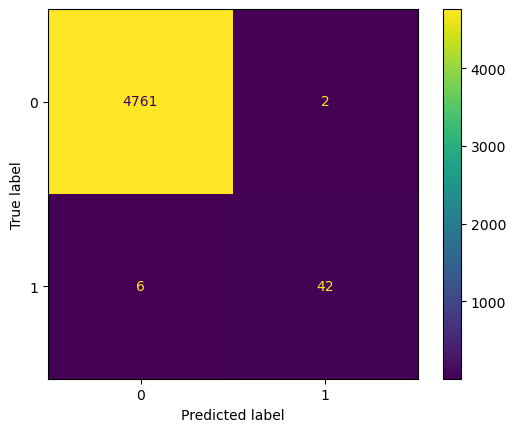

In [48]:
cdtx_display1 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new)
cdtx_display1.plot()
plt.show()

第二種選擇 fs_score > 0

In [49]:
cdtx_X_train_new2 = cdtx_X_train[['risk_rank','AGE','total_asset','cycam','country','cur_type','amt','date']]
cdtx_X_test_new2 = cdtx_X_test[['risk_rank','AGE','total_asset','cycam','country','cur_type','amt','date']]
cdtx_X_test_new2

,risk_rank,AGE,total_asset,cycam,country,cur_type,amt,date
15362,1,6,2287681.0,1503243.0,130,47,2336.0,20
21928,3,3,991292.0,312011.0,52,13,12840.0,26
46113,1,3,27396.0,201307.0,44,47,813.0,267
32837,1,2,326296.0,292963.0,135,46,5737.0,117
24270,3,3,797756.0,312011.0,134,30,212.0,35
...,...,...,...,...,...,...,...,...
41021,1,3,160933.0,402038.0,130,47,86214.0,194
19784,3,3,332090.0,522800.0,43,47,1031.0,99
9746,3,5,2815277.0,402456.0,130,47,332.0,348
13948,3,3,517214.0,418264.0,130,47,125479.0,42


In [50]:
cdtx_ct_new2 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[0,1,4,5,7]),('std',StandardScaler(),[2,3,6])], remainder='passthrough')
cdtx_X_train_new2_T = cdtx_ct_new.fit_transform(cdtx_X_train_new2)
cdtx_X_test_new2_T = cdtx_ct_new.transform(cdtx_X_test_new2)

In [51]:
cdtx_X_train_new2_T

<43296x3471 sparse matrix of type '<class 'numpy.float64'>'
	with 346037 stored elements in Compressed Sparse Row format>

In [103]:
cdtx_classfier_new2 = KNeighborsClassifier(n_neighbors=3, metric='minkowski',p=2)
cdtx_classfier_new2.fit(cdtx_X_train_new2_T, cdtx_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=11)

In [104]:
cdtx_y_pred_new2 = cdtx_classfier_new2.predict(cdtx_X_test_new2_T)
cdtx_cm_new2 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new2)
print(cdtx_cm_new2)

[[4761    2]
 [  23   25]]


In [105]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new2)*100))

Test set Accuracy: 99.48 %


In [75]:
25/48

0.5208333333333334

n_neighbors = 5 時, Accuracy = 99.54 % 且對 sar_flag = 1 的判斷準確率為 0.604
n_neighbors = 3 時, Accuracy = 99.56 % 且對 sar_flag = 1 的判斷準確率為 0.66
n_neighbors = 2 時, Accuracy = 99.63 % 且對 sar_flag = 1 的判斷準確率為 0.66
n_neighbors = 11 時, Accuracy = 99.48 % 且對 sar_flag = 1 的判斷準確率為 0.52

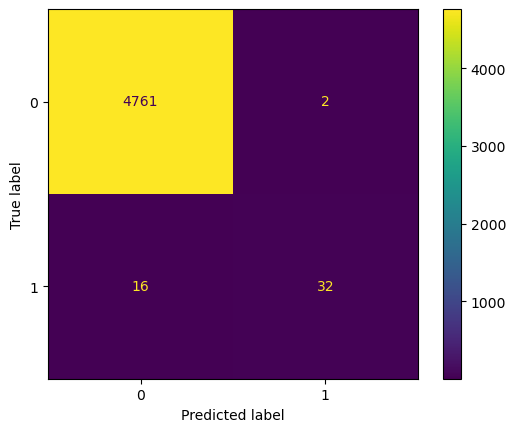

In [79]:
cdtx_display2 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new2)
cdtx_display2.plot()
plt.show()

第三種選擇 fs_score 前兩名

In [80]:
cdtx_X_train_new3 = cdtx_X_train[['country','cur_type','total_asset','cycam','amt']]
cdtx_X_test_new3 = cdtx_X_test[['country','cur_type','total_asset','cycam','amt']]

In [81]:
cdtx_ct_new3 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[0,1]),('std',StandardScaler(),[2,3,4])], remainder='passthrough')
cdtx_X_train_new3_T = cdtx_ct_new3.fit_transform(cdtx_X_train_new3)
cdtx_X_test_new3_T = cdtx_ct_new3.transform(cdtx_X_test_new3)

In [82]:
cdtx_X_train_new3_T

<43296x92 sparse matrix of type '<class 'numpy.float64'>'
	with 216480 stored elements in Compressed Sparse Row format>

In [98]:
cdtx_classfier_new3 = KNeighborsClassifier(n_neighbors=3, metric='minkowski',p=2)
cdtx_classfier_new3.fit(cdtx_X_train_new3_T, cdtx_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [99]:
cdtx_y_pred_new3 = cdtx_classfier_new3.predict(cdtx_X_test_new3_T)
cdtx_cm_new3 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new3)
print(cdtx_cm_new3)

[[4761    2]
 [  19   29]]


In [100]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new3)*100))

Test set Accuracy: 99.56 %


In [101]:
22/48

0.4583333333333333

n_neighbors = 5 時, Accuracy = 99.4 % 且對 sar_flag = 1 的判斷準確率為 0.6875
n_neighbors = 3 時, Accuracy = 99.56 % 且對 sar_flag = 1 的判斷準確率為 0.604
n_neighbors = 2 時, Accuracy = 99.61 % 且對 sar_flag = 1 的判斷準確率為 0.604
n_neighbors = 11 時, Accuracy = 99.48 % 且對 sar_flag = 1 的判斷準確率為 0.458

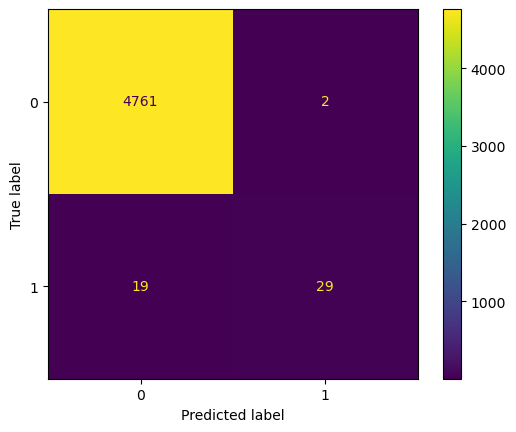

In [102]:
cdtx_display3 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new3)
cdtx_display3.plot()
plt.show()